In [ ]:
# 데이터 업로드 후 확인
from google.colab import files
import pandas as pd

data = pd.read_csv('/content/sample_data/final_crawled_api_data.csv')

#결측값 제거
data = data.dropna()

#상관없는 변수 제거
column_to_drop = ['title', 'link', 'upload_to', 'mountain', '위치']
data = data.drop(columns = column_to_drop)

#영어로 변환
korean_column_names = ['운해 여부', '전날 기온', '전날 강수량', '전날 습도', '전날 기압', '일출 기온', '일출 풍속', '일출 습도', '일출 기압', '일출 전운량', '일교차']
english_column_names = ['isCloudSea', 'Previous Temperature', 'Previous Precipitation', 'Previous Humidity', 'Previous Pressure', 'Sunrise Temperature', 'Sunrise Wind Speed', 'Sunrise Humidity', 'Sunrise Pressure', 'Sunrise Cloud Coverage', 'Diurnal Temperature Range']
new_column_names = {}
for korean, english in zip(korean_column_names, english_column_names):
    new_column_names[korean] = english
data = data.rename(columns = new_column_names)

data.tail()

,isCloudSea,Previous Temperature,Previous Precipitation,Previous Humidity,Previous Pressure,Sunrise Temperature,Sunrise Wind Speed,Sunrise Humidity,Sunrise Pressure,Sunrise Cloud Coverage,Diurnal Temperature Range
801,1.0,24.0,0.0,90.0,990.1,24.1,0.0,90.0,989.8,0.0,0.1
802,0.0,-10.8,0.0,89.0,941.9,-13.1,0.3,87.0,941.8,0.0,-2.3
803,0.0,-4.5,0.0,61.0,1008.7,-7.0,0.6,72.0,1008.7,0.0,-2.5
804,0.0,8.5,0.0,76.0,1015.7,7.7,0.3,85.0,1015.7,0.0,-0.8
805,0.0,-5.0,0.0,73.0,1009.7,-5.8,0.0,83.0,1009.7,0.0,-0.8


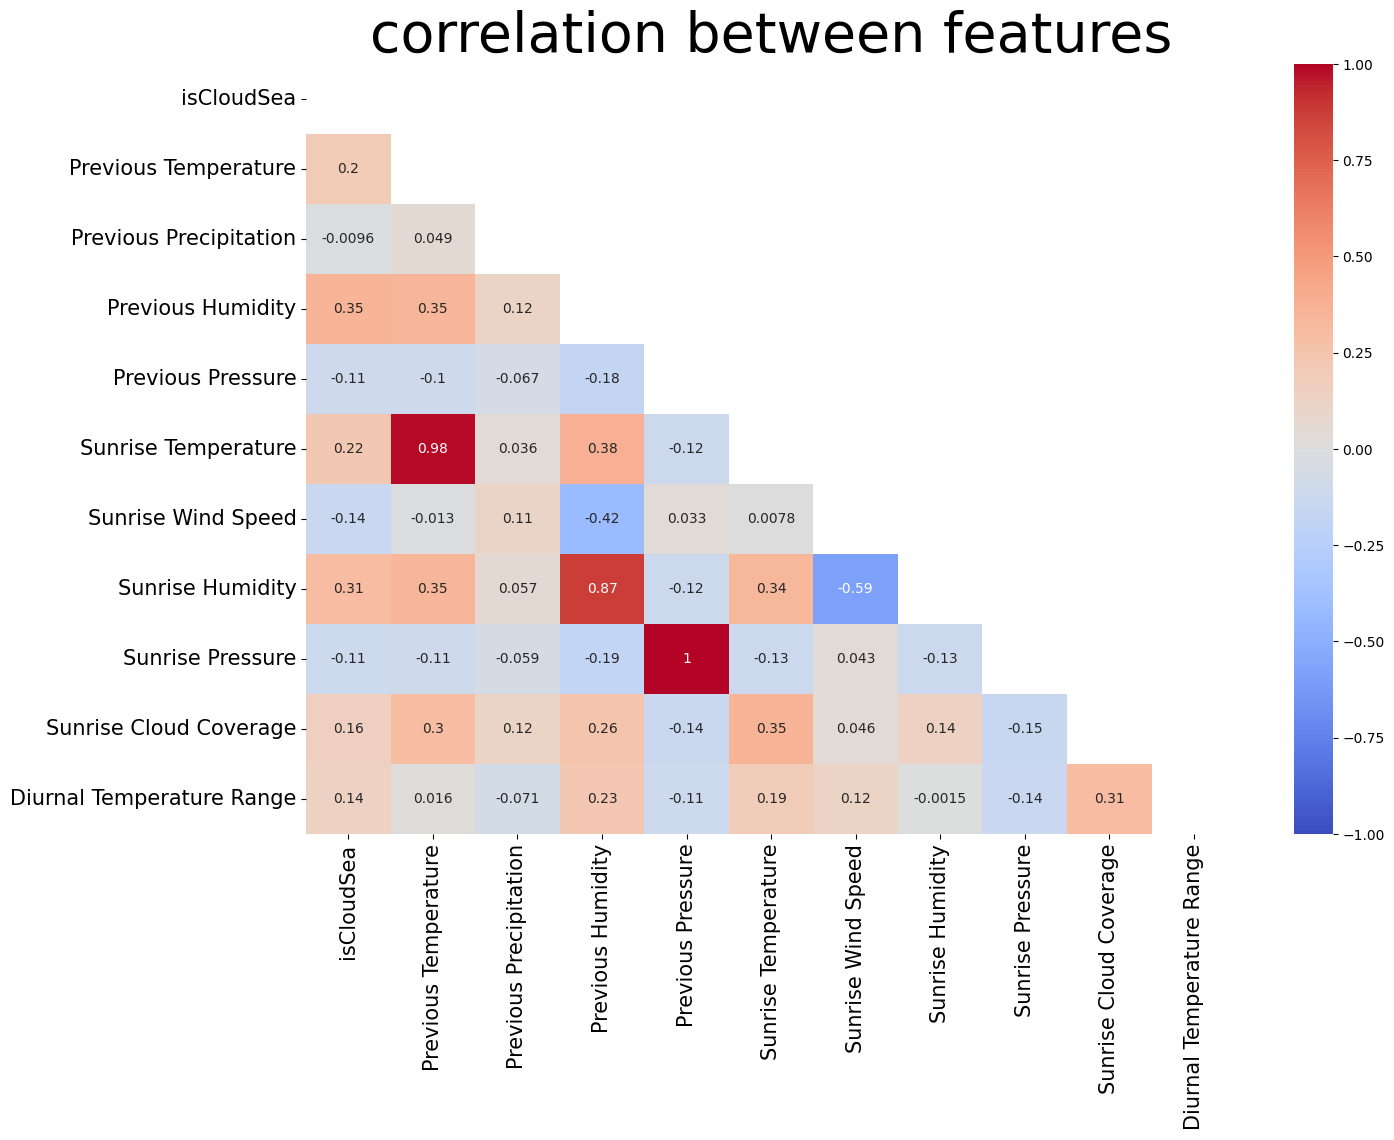

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#상관관계 분석도
plt.figure(figsize=(15,10))

heat_table = data.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm', vmin=-1, vmax=1)
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=90)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X = data[['Previous Temperature', 'Previous Precipitation', 'Previous Humidity', 'Previous Pressure', 'Sunrise Temperature', 'Sunrise Wind Speed', 'Sunrise Humidity', 'Sunrise Pressure', 'Sunrise Cloud Coverage', 'Diurnal Temperature Range']]
y = data[['isCloudSea']]

#훈련,테스트 데이터셋 분류 -> 같은 레코드를 추출하기 위해 random_state를 정하지만
#모델 내부 트리를 만드는 과정에서 샘플링된 데이터를 선택하는데 이때문에 정확도는 계속 다르게 나올것으로 예상됨.
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(642, 10) (161, 10) (642, 1) (161, 1)


In [ ]:

rf_model = RandomForestClassifier(n_estimators=10000) #n_estimators : 트리 개수
rf_model.fit(X_train,y_train)#학습 데이터 학습
#학습하면서 생성된 랜덤포레스트 내부 트리는 estimator_ 에 저장된다.

print(rf_model.score(X_train,y_train))
print(rf_model.score(X_test,y_test))#분류 모델의 score 메서드는 정확도 (accuracy_score) 리턴 #내부적으로 predict


<ipython-input-59-774678f72f45>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train,y_train)#학습 데이터 학습


0.9766355140186916
0.7142857142857143


In [ ]:
from sklearn.metrics import accuracy_score

pred = rf_model.predict(X_test) #학습된 모델을 통해 X_test로 부터 라벨 예측
print(pred[:10])
print(y_test[:10])
accuracy = accuracy_score(y_test, pred)
accuracy

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
     isCloudSea
514         1.0
484         0.0
244         0.0
383         0.0
220         0.0
495         0.0
802         0.0
476         0.0
120         0.0
502         0.0


0.7142857142857143

랜덤포레스트를 활용했음에도 여전히 정확도가 높지는않음.
기존 훈련된 모델에 대해서는 예측정확도가 높은것으로 보아 오버피팅이 여전히 존재함.